Experiment to test the impact of training distribution on what the system predicts when it has no clues to determine the gender of a word.

Trains 20 models for each of the 5 different distributions and measures the percentage of predictions corresponding to the majority class at train time for words that have only been encountered in an ambiguous context by the models (AUA).

## Requirements

In [69]:
import json
from collections import defaultdict
from pcfg import PCFG
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pathlib
import tempfile
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from IPython.utils import io
import re
import os

In [70]:
device = 'cuda:1'

## Get vocabulary

In [71]:
with open('full_vocabulary.json', 'r') as openfile:
    full_vocab = json.load(openfile)

## Data auxiliary functions

In [72]:
# Non-terminal productions
def generate_NT_rules(prob_fem):
    return f"""
S -> NP VP "."[1.0]

PP -> PREP NP [1.0]
VP -> VERB [0.5] | VERB NP [0.5]

NP -> NPGend [0.4] | NPAmb [0.4] | NP PP [0.20]

NPGend -> DETFem npGendFem [{prob_fem}] | DETMasc npGendMasc [{1-prob_fem}]
npGendFem -> NOUNFemGend [0.4] | ADJFem NOUNFemGend [0.3] | NOUNFemGend ADJFem [0.3] 
npGendMasc -> NOUNMascGend [0.4] | ADJMasc NOUNMascGend [0.3] | NOUNMascGend ADJMasc [0.3] 

NPAmb -> DETEpic npAmbFem [0.5] | DETEpic npAmbMasc [0.5]
npAmbFem -> NOUNFemAmb [0.4] | ADJEpic NOUNFemAmb [0.3] | NOUNFemAmb ADJEpic [0.3] 
npAmbMasc -> NOUNMascAmb [0.4] | ADJEpic NOUNMascAmb [0.3] | NOUNMascAmb ADJEpic [0.3]

NOUNFemAmb -> NOUNFemAG [0.5] | NOUNFemAU [0.5]
NOUNMascAmb -> NOUNMascAG [0.5] | NOUNMascAU [0.5]
NOUNFemGend -> NOUNFemGG [0.5] | NOUNFemGU [0.5]
NOUNMascGend -> NOUNMascGG [0.5] | NOUNMascGU [0.5]


"""
# A stands for ambiguous context
# G for gendered context
# U for unseen (these words will not be seen when training the probe)

In [73]:
# Choose subset of full vocabulary to be used
def generate_vocab(full_vocab, prob_fem):
    prob_masc = 1-prob_fem
    nwords = {'VERB':20, 'ADJMasc':int(200*prob_masc), 'NOUNMasc':int(400*prob_masc), 'ADJFem':int(200*prob_fem), 'NOUNFem':int(400*prob_fem),  
            'ADJEpic':100, 'PREP':5, 'DETEpic':5, 'DETMasc':5, 'DETFem':5}
            
    train_vocab = {}

    # convert to list  
    for k in nwords:
        if k in {'NOUNMasc', 'NOUNFem'}:
            train_vocab[k + 'AG'] = full_vocab[k][:nwords[k]//4]
            train_vocab[k + 'AU'] = full_vocab[k][nwords[k]//4:nwords[k]//2]
            train_vocab[k + 'GG'] = full_vocab[k][nwords[k]//2:nwords[k]*3//4]
            train_vocab[k + 'GU'] = full_vocab[k][nwords[k]*3//4:nwords[k]]
        else:
            train_vocab[k] = full_vocab[k][:nwords[k]]

    return train_vocab

In [74]:
# Compute probability of each word

def generate_word_probabilities(train_vocab):
    train_probs = defaultdict(lambda: dict()) # dictionary that maps non terminal symbols to dictionaries that map words to probabilities

    for non_term in train_vocab:
        for k,w in enumerate(train_vocab[non_term]):
            N = len(train_vocab[non_term])
            k = k+1
            if k != N: 
                # following a zipfian distribution
                denominateur = sum(1/n for n in range(1,N+1))
                train_probs[non_term][w] = (1/k)/denominateur
            else: # last word
                train_probs[non_term][w] = 1 - sum(train_probs[non_term].values())
        assert sum(train_probs[non_term].values()) == 1.0 # probabilites of all terminals must add to 1

    return train_probs


In [75]:
# Terminal productions
def generate_T_rules(train_probs):
    return "\n".join(f"{non_term} -> " + " | ".join(f'"{w}" [{train_probs[non_term][w]}]' for w in train_probs[non_term]) for non_term in train_probs)

## Create train probe PCFG

In [76]:
# Non-terminal productions
train_probe_rules = """
S -> NP VP "."[1.0]

PP -> PREP NP [1.0]
VP -> VERB [0.5] | VERB NP [0.5]

NP -> NPGend [0.8] | NP PP [0.20]

NPGend -> DETFem npGendFem [0.5] | DETMasc npGendMasc [0.5]
npGendFem -> NOUNFemGend [0.4] | ADJFem NOUNFemGend [0.3] | NOUNFemGend ADJFem [0.3] 
npGendMasc -> NOUNMascGend [0.4] | ADJMasc NOUNMascGend [0.3] | NOUNMascGend ADJMasc [0.3] 

NOUNFemGend -> NOUNFemGG [0.5] | NOUNFemAG [0.5]
NOUNMascGend -> NOUNMascGG [0.5] | NOUNMascAG [0.5]


"""
# Only gendered contexts and nouns marked as U (unseen) are not used

## Auxiliary functions

In [77]:
model_config = """
context_model : 'GPT' #one of 'RNN', 'LSTM', 'GPT'
model_input_size:  [256]
model_output_size: [256]
num_layers: [3]
max_vocab_size: 50000 #Gulordava setup
nheads : [4]  #for GPT only
ffn_hidden : [1024]   #for GPT only
tie_weights : True
dropout: [0.3]
epochs: [100]
batch_size: [64] 
bptt_chunk : [512]     #size of context for truncated BPTT
learning_rate: [0.0005]
warmup_epochs: [1]       #number of epochs for warmup
warmup_batch_size : [8]  #size of batches during warmup
restart_cycles: [4]      #number or warmup restarts for GPT only
positional : True        #use positional embeddings or ignore them
"""

In [78]:
pos2label = lambda pos: 'Fem' if 'Fem' in pos else 'Masc'

In [79]:
def generate_model_data(directory_name, pcfg_rules, word_probabilities, pos2label, w2pos):
    train_grammar = PCFG.fromstring(pcfg_rules)

    train_data = '\n'.join(sent for sent in train_grammar.generate(10_000))
    with open(directory_name + "/train_model_data.txt", "w") as outfile:
        outfile.write(train_data)

    dev_data = '\n'.join(sent for sent in train_grammar.generate(1_000))
    with open(directory_name + "/dev_model_data.txt", "w") as outfile:
        outfile.write(dev_data)
    
    # Check for OOVs
    train_words = {word for word in train_data.split()}
    if not all(w in train_words for k in word_probabilities for w in word_probabilities[k]):
        return generate_model_data(directory_name, pcfg_rules, word_probabilities, pos2label, w2pos)

    # Return gender distribution
    train_nouns = [pos2label(w2pos[w]) for w in train_data.split() if 'NOUN' in w2pos.get(w, '')]
    df = pd.Series(train_nouns).value_counts()
    return {'fem_in_model_data': df['Fem'], 'masc_in_model_data': df['Masc']}

In [80]:
def train_model(directory_name, model_config):
    # returns perplexity on dev set
    !mkdir {directory_name}/model
    with open(f"{directory_name}/model/model.yaml", "w") as f:
        f.write(model_config)
    cmd = f"python Lm4Ling/nnlm.py {directory_name}/model --train_file {directory_name}/train_model_data.txt --valid_file {directory_name}/dev_model_data.txt --device_name {device}"
    cmd_output = os.popen(cmd).read()
    return {'perplexity': float(re.findall("Perplexity (.*)[\r|\n]", cmd_output)[0])}

In [81]:
def generate_probe_data(directory_name, pcfg_rules):
    train_probe_grammar = PCFG.fromstring(pcfg_rules)
    with open(directory_name + "/train_probe_data.txt", "w") as outfile:
        outfile.write('\n'.join(sent for sent in train_probe_grammar.generate(1_000)))

In [82]:
def train_probe(directory_name, w2pos):
    # returns gender distribution in the probe training data and the probe
    !python Lm4Ling/nnlm.py {directory_name}/model --probe_ex_file {directory_name}/train_probe_data.txt --out_pickle {directory_name}/probe_train_ex.pk --device_name {device}
    
    df_train = pd.read_pickle(f"{directory_name}/probe_train_ex.pk")
    df_train['pos'] = df_train['tokens'].apply(lambda w: w2pos.get(w,'NotFound'))
    df_train = df_train[df_train.pos.str.startswith('NOUN')]
    X_train = df_train["vectors"].tolist()  
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

    # Prepare labels    
    y_train = df_train['pos'].apply(pos2label).tolist()

    # Train classifier
    classifier = LogisticRegression(penalty = 'l2', solver = 'saga', C=10)
    classifier.fit(X_train, y_train)

    dist = pd.Series(y_train).value_counts()
    return classifier, scaler, {'fem_in_probe_data': dist['Fem'], 'masc_in_probe_data': dist['Masc']}

In [83]:
def generate_rules(train_model, train_probe, test_probe, terminal_rules):
    """
    Produces the appropriate set of rules according to whether the words appeared
    in a gendered or ambiguous context when training the model, whether they appeared or not
    when training the probe and whether they should appear in a gendered or ambiguous context at train time
    """
    rules = f"""
    S -> NP VP "."[1.0]

    PP -> PREP NP [1.0]
    VP -> VERB [0.5] | VERB NP [0.5]

    NOUNFem -> NOUNFem{train_model[0].upper()}{train_probe[0].upper()} [1.0]
    NOUNMasc -> NOUNMasc{train_model[0].upper()}{train_probe[0].upper()} [1.0]
    """
    if test_probe == 'gendered context':
        return rules + """
            NP -> NPGend [0.8] | NP PP [0.20]

            NPGend -> DETFem npGendFem [0.5] | DETMasc npGendMasc [0.5]
            npGendFem -> NOUNFem [0.4] | ADJFem NOUNFem [0.3] | NOUNFem ADJFem [0.3] 
            npGendMasc -> NOUNMasc [0.4] | ADJMasc NOUNMasc [0.3] | NOUNMasc ADJMasc [0.3] 


            """ + terminal_rules
    if test_probe == 'ambiguous context':
        return rules + """
            NP -> NPAmb [0.8] | NP PP [0.20]

            NPAmb -> DETEpic npAmbFem [0.5] | DETEpic npAmbMasc [0.5]
            npAmbFem -> NOUNFem [0.4] | ADJEpic NOUNFem [0.3] | NOUNFem ADJEpic [0.3] 
            npAmbMasc -> NOUNMasc [0.4] | ADJEpic NOUNMasc [0.3] | NOUNMasc ADJEpic [0.3]


            """ + terminal_rules

In [84]:
def test_probe(directory_name, terminal_rules, w2pos, scaler, classifier):
    res = {}
    for train_model in ['gendered context', 'ambiguous context']:
            for train_probe in ['gendered context', 'unseen']:
                for test_probe in ['gendered context', 'ambiguous context']:
                    test_rules = generate_rules(train_model, train_probe, test_probe, terminal_rules).replace('    ', '')             
                    test_grammar = PCFG.fromstring(test_rules)
                    
                    with open(directory_name + "/test_data.txt", "w") as outfile:
                        outfile.write('\n'.join(sent for sent in test_grammar.generate(1_000)))
                    
                    with io.capture_output() as captured:
                        !python Lm4Ling/nnlm.py {directory_name}/model --probe_ex_file {directory_name + "/test_data.txt"} --out_pickle {directory_name + "/test_ex.pk"} --device_name {device}
                                    
                    df_test = pd.read_pickle(directory_name + "/test_ex.pk")
                    df_test['pos'] = df_test['tokens'].apply(lambda w: w2pos.get(w, 'NotFound'))
                    df_test = df_test[df_test.pos.str.startswith('NOUN')]
                    X_test = df_test["vectors"].tolist()  
                    X_test = scaler.transform(X_test)
                    y_test = df_test['pos'].apply(pos2label).tolist()

                    code = train_model[0].upper() + train_probe[0].upper() + test_probe[0].upper()
                    res["accuracy_" + code] = classifier.score(X_test, y_test)

                    if code == "AUA":
                        y_hat_test = classifier.predict(X_test)
                        confusion_list = confusion_matrix(y_test, y_hat_test, labels=['Masc','Fem']).flatten()
                        res['true_masc_AUA'], res['false_fem_AUA'], res['false_masc_AUA'], res['true_fem_AUA'] = confusion_list
    return res

# Main loop

In [ ]:
# Folder where results are saved

if not os.path.exists("results/exp_default_guess/"): 
    os.makedirs("results/exp_default_guess/") 

In [ ]:
columns = ['perplexity', 'fem_in_model_data', 'masc_in_model_data', 'fem_in_probe_data', 'masc_in_probe_data', 
           'accuracy_GGG', 'accuracy_GGA', 'accuracy_GUG', 'accuracy_GUA', 
           'accuracy_AGG', 'accuracy_AGA', 'accuracy_AUG', 'accuracy_AUA', 
           'true_fem_AUA', 'false_fem_AUA', 'false_masc_AUA', 'true_masc_AUA']


for prob_fem in [0.4, 0.3, 0.2, 0.1]:
    data_df = []

    # do everything in a temp file
    for i in range(20):
        print(f"-------------------------------- ITERATION {i} --------------------------------")
        with tempfile.TemporaryDirectory() as directory_name:
            #temp_dir = str(pathlib.Path(directory_name))
            row = {}

            # generate and save train and dev sets and get gender distribution
            train_NT_rules = generate_NT_rules(prob_fem)
            train_vocab = generate_vocab(full_vocab, prob_fem)
            train_probs = generate_word_probabilities(train_vocab)
            terminal_rules = generate_T_rules(train_probs)
            train_model_rules = train_NT_rules + terminal_rules
            w2pos = {w: pos for pos in train_vocab for w in train_vocab[pos]}
            row.update(generate_model_data(directory_name, train_model_rules, train_probs, pos2label, w2pos))

            # train model and get perplexity
            row.update(train_model(directory_name, model_config))

            # generate probe training data
            generate_probe_data(directory_name, train_probe_rules+terminal_rules)
            
            # train probe and get gender distribution in data
            classifier, scaler, probe_dist = train_probe(directory_name, w2pos)
            row.update(probe_dist)

            # test the probe for all configurations and get accuracies and confusion matrix for AUA
            row.update(test_probe(directory_name, terminal_rules, w2pos, scaler, classifier))
            data_df.append(row)

    df = pd.DataFrame(columns=columns, data=data_df)
    df.to_json(f"results/exp_default_guess/entire_df_{round(prob_fem*100)}_{(round(1-prob_fem)*100)}.json")


## Analyse results

In [88]:
df_50 = pd.read_json("results/exp_default_guess/entire_df_50_50.json")
df_40 = pd.read_json("results/exp_default_guess/entire_df_40_60.json")
df_30 = pd.read_json("results/exp_default_guess/entire_df_30_70.json")
df_20 = pd.read_json("results/exp_default_guess/entire_df_20_80.json")
df_10 = pd.read_json("results/exp_default_guess/entire_df_10_90.json")

In [96]:
def compute_bias(df):
    if df.fem_in_model_data > df.masc_in_model_data:
        return ((df.true_fem_AUA+df.false_fem_AUA)*2 / (df.true_fem_AUA+df.false_fem_AUA+df.false_masc_AUA+df.true_masc_AUA))-1
    else:
        return ((df.true_masc_AUA+df.false_masc_AUA)*2 / (df.true_fem_AUA+df.false_fem_AUA+df.false_masc_AUA+df.true_masc_AUA))-1
    
for df, proportion in [(df_50,"50%"), (df_40,"40%"), (df_30,"30%"), (df_20,"20%"), (df_10,"10%")]:
    df['proportion'] = proportion
    df['default_bias'] = df.apply(compute_bias, axis=1)

In [104]:
df = pd.concat([df_50, df_40, df_30, df_20, df_10], axis=0)

[Text(0.5, 0, 'Proportion of feminine nouns in the training data'),
 Text(0, 0.5, 'Degree of bias')]

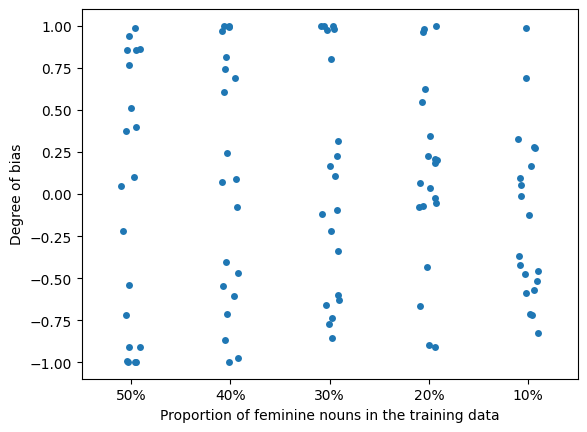

In [117]:
sns.stripplot(data=df, x="proportion", y="default_bias").set(xlabel='Proportion of feminine nouns in the training data',
                                                             ylabel='Degree of bias')